# predicting OnMarket 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import datetime
from datetime import timedelta
import ast
import json    
import missingno as msno
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.impute import SimpleImputer
# from sklearn_pandas import CategoricalImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
# Helper packages
from plotnine import *

# Modeling packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool

from collections import defaultdict

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm


## i will use in all the models 5 cross vaildation and MRSE to measure the ERROR 

In [23]:
loss = 'neg_root_mean_squared_error'
k = 5 #k-fold

In [24]:
df = pd.read_csv('../data/ML.csv')
df['user_id'] = df['user_id'].astype('object')

delete outliers as in the EDA

In [25]:
df =df[df['beds'] <=5]
df = df.loc[(df['review'] > 3) | (df['review'] == 1)]
df = df[df['price'] <=100*1000]
df = df[df['isRent']==True]
df = df[df['onMarket']<=75]

In [26]:
df.drop(['createYEAR'],axis=1 ,inplace=True)
df.drop(['createDAY'],axis=1 ,inplace=True)
df.drop(['createMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateDAY'],axis=1 ,inplace=True)
df.drop(['lUpdateMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateYEAR'],axis=1 ,inplace=True)
df.drop(['id'],axis=1 ,inplace=True)

In [27]:

X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent'  , 'onMarket'  ] , axis=1)
y = df['onMarket']

In [28]:
X.columns

Index(['user_id', 'len_of_title', 'price', 'len_of_content', 'img_in_posd',
       'beds', 'livings', 'wc', 'area', 'street_width', 'age', 'ketchen', 'ac',
       'furnished', 'district', 'advertiser_type', 'review', 'profileImg',
       'iam_verified', 'zone'],
      dtype='object')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_df = X_train.join(y_train)
test_df =X_test.join(y_test)

low varince

In [30]:
nzv = VarianceThreshold(threshold=0.1)

dealing with Skewness

In [31]:
yj = PowerTransformer(method="yeo-johnson")
# X_norm = ColumnTransformer([("norm", yj, selector(dtype_include="number"))])

Standardization

In [32]:
scaler = StandardScaler()

# standardize all numeric features
# std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

OneHotEncoder for advertiser_type

In [33]:
encoder = OneHotEncoder(handle_unknown="ignore")


rediction the dim

In [34]:
# pca = PCA(n_components=11)


In [35]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),
  ("norm", yj, selector(dtype_include="number")),
  ("std_encode", scaler, selector(dtype_include="number")),
  # ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

In [36]:
from sklearn.linear_model import RidgeCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence

# RidgeCV

In [37]:
alphas = [1,10 , 20]
reg = RidgeCV(alphas= alphas , store_cv_values=True)

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("reg", reg),
])
cb_reg_1 = model_pipeline.fit(X_train , y_train)
cv_MSE = np.mean(reg.cv_values_, axis=0)

In [38]:
alphas

[1, 10, 20]

In [39]:
cv_MSE

array([247.45161418, 255.3278743 , 264.78424865])

In [40]:
reg.alpha_

1

In [41]:
results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
np.abs(np.mean(results))

16.7650238503141

# catBoost


In [42]:

cb_reg_1 = CatBoostRegressor( random_seed=13, verbose=200)

pipeline  = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("cb_reg_1", cb_reg_1),
])
pipeline.fit(X_train , y_train)
# scores = cross_val_score(model_pipeline, X_train, y_train, cv = 5 )
# scores = GridSearchCV(model_pipeline, X_train, y_train , cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)


Learning rate set to 0.046011
0:	learn: 17.7263149	total: 52.7ms	remaining: 52.6s
200:	learn: 14.4428067	total: 468ms	remaining: 1.86s
400:	learn: 13.0261412	total: 880ms	remaining: 1.31s
600:	learn: 12.0007842	total: 1.28s	remaining: 848ms
800:	learn: 11.2396419	total: 1.65s	remaining: 410ms
999:	learn: 10.5479946	total: 2.06s	remaining: 0us


In [43]:

np.abs(np.mean(results))

16.7650238503141

-----------

In [44]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, one_hot_encode=False,
                   combine_min_cats=False, add_pca_feats=False):
        """ Preprocess train / test as required """
        
        # if training, fit our transformers
        if train:
            self.train_ids = data_df.loc[:, 'id']
            train_cats = data_df.loc[:, data_df.dtypes == object]
            self.cat_cols = train_cats.columns
            
            # if selected, combine minority categorical feats
            if combine_min_cats:
                self._find_minority_cats(train_cats)
                train_cats = self._combine_minority_feats(train_cats)
            
            # if selected, one hot encode our cat features
            if one_hot_encode:
                self.encoder = OneHotEncoder(handle_unknown='ignore')
                oh_enc = self.encoder.fit_transform(train_cats).toarray()
                train_cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names(), 
                                              dtype=np.int64)
                self.final_cat_cols = list(train_cats_enc.columns)
            
            # otherwise just encode our cat feats with ints
            else:
                # encode all of our categorical variables
                self.encoder = defaultdict(LabelEncoder)
                train_cats_enc = train_cats.apply(lambda x: 
                                                  self.encoder[x.name].fit_transform(x))
                self.final_cat_cols = list(self.cat_cols)
            
            
            # standardise all numerical columns
            train_num = data_df.loc[:, data_df.dtypes != object].drop(columns=['onMarket', 'id'])
            self.num_cols = train_num.columns
            self.standard_scaler = StandardScaler()
            train_num_std = self.standard_scaler.fit_transform(train_num)
            
            # add pca reduced num feats if selected, else just combine num + cat feats
            if add_pca_feats:
                pca_feats = self._return_num_pca(train_num_std)
                self.final_num_feats = list(self.num_cols)+list(self.pca_cols)
                
                
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            else:   
                self.final_num_feats = list(self.num_cols)
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols))
        
        # otherwise, treat as test data
        else:
            # transform categorical and numerical data
            self.test_ids = data_df.loc[:, 'id']
            cat_data = data_df.loc[:, self.cat_cols]
            if combine_min_cats:
                cat_data = self._combine_minority_feats(cat_data)
        
            if one_hot_encode:
                oh_enc = self.encoder.transform(cat_data).toarray()
                cats_enc = pd.DataFrame(oh_enc, 
                                        columns=self.encoder.get_feature_names(), 
                                        dtype=np.int64)
            else:
                cats_enc = cat_data.apply(lambda x: self.encoder[x.name].transform(x))
                
            # transform test numerical data
            num_data = data_df.loc[:, self.num_cols]
            num_std = self.standard_scaler.transform(num_data)
            
            if add_pca_feats:
                pca_feats = self._return_num_pca(num_std, train=False)
                
                X = pd.DataFrame(np.hstack((cats_enc, num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            
            else:
                X = pd.DataFrame(np.hstack((cats_enc, num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)) 
        return X
    
    
    def _find_minority_cats(self, data_df, composite_category='z', threshold=0.05):
        """ Find minority categories for each feature column, and create a 
            dictionary that maps those to selected composite category """
        self.min_col_dict = {}
        self.min_cat_mappings = {}
    
        # find all feature categories with less than 5% proportion
        for feature in self.cat_cols:
            self.min_col_dict[feature] = []
            self.min_cat_mappings[feature] = {}
        
            for category, proportion in data_df[feature].value_counts(normalize=True).iteritems():
                if proportion < threshold:
                    self.min_col_dict[feature].append(category)
                
                    # map those minority cats to chosen composite feature
                    self.min_cat_mappings[feature] = {x : composite_category for x 
                                                    in self.min_col_dict[feature]}
    
    
    def _combine_minority_feats(self, data_df, replace=False):
        """ Combine minority categories into composite for each cat feature """
        new_df = data_df.copy()
        for feat in self.cat_cols:
            col_label = f"{feat}" if replace else f"{feat}_new"
            new_df[feat] = new_df[feat].replace(self.min_cat_mappings[feat])
        return new_df
    
    
    def _return_num_pca(self, num_df, n_components=0.85, train=True):
        """ return dim reduced numerical features using PCA """
        if train:
            self.pca = PCA(n_components=n_components)
            num_rd = self.pca.fit_transform(num_df)
            
            # create new col names for our reduced features
            self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
            
        else:
            num_rd = self.pca.transform(num_df)
        
        return pd.DataFrame(num_rd, columns=self.pca_cols)

In [45]:
PCA_FEATS = True
ONE_HOT_ENCODE = True

data_proc = DataProcessor()
X = data_proc.preprocess(train_df, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)
y = train_df.loc[:, 'onMarket']
X_test = data_proc.preprocess(test_df, train=False, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)

print(f"X: {X.shape} \ny: {y.shape} \nX_test: {X_test.shape}")

KeyError: 'id'

In [ ]:
# convert all of our categorical columns to ints before using GBMs
cat_feat_dtype_dict = { x : "int" for x in data_proc.final_cat_cols}
X = X.astype(cat_feat_dtype_dict)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

X_train: (1674, 878) 
y_train: (1674,) 
X_val: (419, 878), 
y_val: (419,)


In [ ]:
_, X_sub, _, y_sub = train_test_split(X, y, test_size=0.05)
X_sub.shape, y_sub.shape

((105, 878), (105,))

In [ ]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.2)
X_train_sub.shape, X_val_sub.shape, y_train_sub.shape, y_val_sub.shape

((84, 878), (21, 878), (84,), (21,))

In [ ]:
cb_reg_1 = CatBoostRegressor( random_seed=13, verbose=200)

In [ ]:
cb_reg_1.fit(X_train, y_train)
cb_preds = cb_reg_1.predict(X_val)

Learning rate set to 0.044415
0:	learn: 17.6011827	total: 2.35ms	remaining: 2.34s
200:	learn: 13.9359054	total: 361ms	remaining: 1.43s
400:	learn: 12.0706944	total: 699ms	remaining: 1.04s
600:	learn: 10.7133670	total: 1.03s	remaining: 686ms
800:	learn: 9.5826463	total: 1.37s	remaining: 340ms
999:	learn: 8.6733240	total: 1.7s	remaining: 0us


In [ ]:
cb_preds = cb_reg_1.predict(X_val)
results = cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(cb_preds, y_val)) , np.abs(np.mean(results))

Learning rate set to 0.035685
0:	learn: 18.0248905	total: 704us	remaining: 704ms
200:	learn: 11.8687226	total: 175ms	remaining: 695ms
400:	learn: 8.5346413	total: 356ms	remaining: 531ms
600:	learn: 5.7916887	total: 500ms	remaining: 332ms
800:	learn: 4.1268006	total: 654ms	remaining: 163ms
999:	learn: 3.0691701	total: 792ms	remaining: 0us
Learning rate set to 0.035685
0:	learn: 17.2113784	total: 22.9ms	remaining: 22.9s
200:	learn: 11.0072453	total: 181ms	remaining: 718ms
400:	learn: 7.9981038	total: 340ms	remaining: 508ms
600:	learn: 5.7036957	total: 486ms	remaining: 323ms
800:	learn: 4.1838851	total: 634ms	remaining: 158ms
999:	learn: 3.1034274	total: 776ms	remaining: 0us
Learning rate set to 0.035685
0:	learn: 17.8973974	total: 1.02ms	remaining: 1.02s
200:	learn: 11.7134874	total: 173ms	remaining: 687ms
400:	learn: 8.0154321	total: 329ms	remaining: 492ms
600:	learn: 5.6028282	total: 493ms	remaining: 327ms
800:	learn: 4.1848307	total: 652ms	remaining: 162ms
999:	learn: 3.1070088	total:

(15.400686251209779, 16.59972748391611)

In [ ]:
params = {'loss_function':'RMSE', 'verbose': 200, 'random_seed': 13}

X_pool = Pool(data=X, label=y, cat_features=data_proc.final_cat_cols)

In [ ]:
catboost_hyperparams = { 'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
                         'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
                         'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
                         'n_estimators': 100, 'eval_metric': 'RMSE'}

catbooast_fit_params = { 'early_stopping_rounds': 10, 'verbose': False }

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catbooast_fit_params
catboost_params['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
class HPOptimiser(object):
    """ Class to optimiser hyper-parameters using hyperopt on a given
        set of training and validation inputs and labels """

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **params['fit_params'])
        pred = reg.predict(self.X_val)
        loss = params['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj = HPOptimiser(X_train_sub, X_val_sub, y_train_sub, y_val_sub)

catboost_opt = obj.process(fn_name='catboost_reg', space=catboost_params, 
                          trials=Trials(), algo=tpe.suggest, max_evals=100)
print("----------------\n",catboost_opt)


 76%|███████▌  | 76/100 [00:11<00:03,  6.77trial/s, best loss: 16.910289096763623]


KeyboardInterrupt: 

In [ ]:
cb_learn_rate = 0.002
n_iterations = 800000
early_stop_rounds = 4800

opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'depth': 7,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 1,
                       'min_data_in_leaf': 10,
                       'l2_leaf_reg': 3,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'grow_policy' : 'Depthwise',
                       'max_bin' : 1024, 
                       'model_size_reg' : 0,
                    #    'task_type' : 'GPU',
                       'od_type' : 'IncToDec',
                       'od_wait' : 100,
                       'metric_period' : 500,
                       'verbose' : 500,
                       'subsample' : 0.8,
                       'od_pval' : 1e-10,
                       'max_ctr_complexity' : 8,
                       'has_time': False,
                       'simple_ctr' : 'FeatureFreq',
                       'combinations_ctr': 'FeatureFreq',
                       'random_seed' : 13}

In [ ]:
cb_reg = CatBoostRegressor()

cb_reg.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=True, 
           early_stopping_rounds=early_stop_rounds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.055211
0:	learn: 17.5724495	test: 17.8483416	best: 17.8483416 (0)	total: 2ms	remaining: 1.99s
1:	learn: 17.5054051	test: 17.8166618	best: 17.8166618 (1)	total: 4.03ms	remaining: 2.01s
2:	learn: 17.4515727	test: 17.7863592	best: 17.7863592 (2)	total: 6.17ms	remaining: 2.05s
3:	learn: 17.4182106	test: 17.7514500	best: 17.7514500 (3)	total: 8.42ms	remaining: 2.1s
4:	learn: 17.3678000	test: 17.7321964	best: 17.7321964 (4)	total: 10.6ms	remaining: 2.1s
5:	learn: 17.3308765	test: 17.6971836	best: 17.6971836 (5)	total: 15.5ms	remaining: 2.57s
6:	learn: 17.2863803	test: 17.6863030	best: 17.6863030 (6)	total: 18.1ms	remaining: 2.57s
7:	learn: 17.2272886	test: 17.6470666	best: 17.6470666 (7)	total: 20.1ms	remaining: 2.49s
8:	learn: 17.1791537	test: 17.6258779	best: 17.6258779 (8)	total: 21.9ms	remaining: 2.41s
9:	learn: 17.1301451	test: 17.6015128	best: 17.6015128 (9)	total: 23.8ms	remaining: 2.35s
10:	learn: 17.0959364	test: 17.5938762	best: 17.5938762 (10)	total: 26ms	re

In [ ]:
val_preds = cb_reg.predict(X_val)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, y_val))

15.561295136073483

In [ ]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6), xlim=[6.5, 9.5]):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', lw=2)
    plt.xlim(xlim)
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

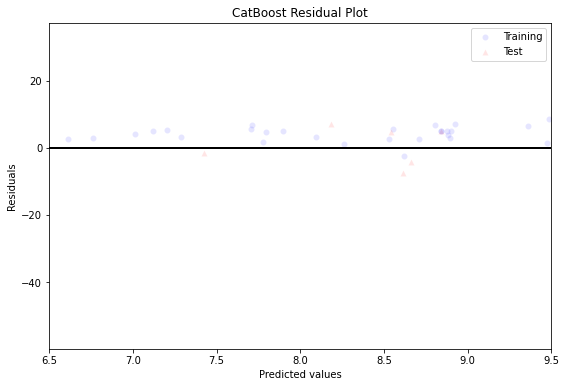

In [ ]:
train_preds = cb_reg.predict(X_train)

residual_plot(y_train[:10000], train_preds[:10000], 
              y_val[:10000], val_preds[:10000], 
              title="CatBoost Residual Plot")

In [ ]:
feat_importances = cb_reg.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,len_of_content,5.761227
1,price,5.286588
2,pca_10,4.628413
3,pca_6,4.357469
4,pca_2,3.979073
...,...,...
891,x1_حي ظهرة البديعة,0.000000
892,x1_حي عتيقة,0.000000
893,x1_حي غبيرة,0.000000
894,x1_حي منفوحة,0.000000


Text(0.5, 1.0, 'CatBoost features importance:')

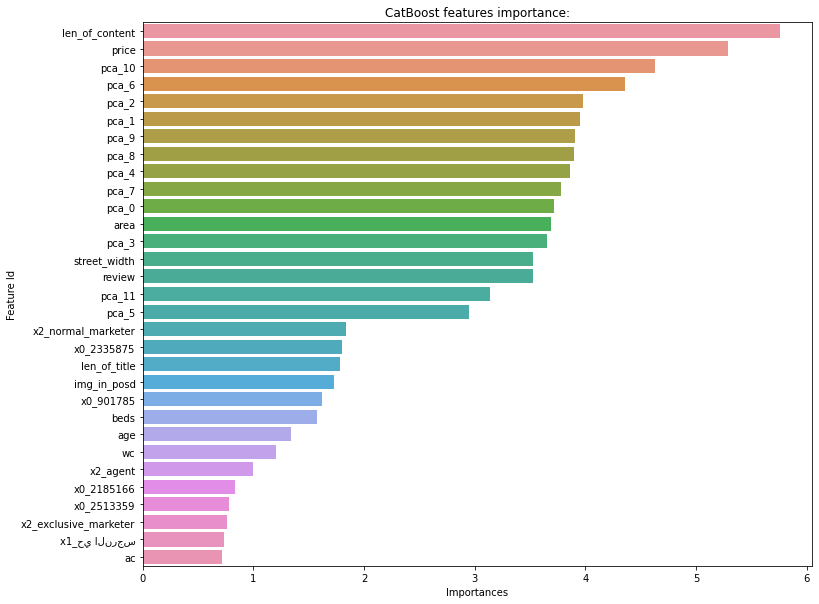

In [ ]:
plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

In [ ]:
train_data = Pool(data=X_train, label=y_train)

val_data = Pool(data=X_val, label=y_val)

In [ ]:
explainer = shap.TreeExplainer(cb_reg_1) 
shap_values = explainer.shap_values(train_data)

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

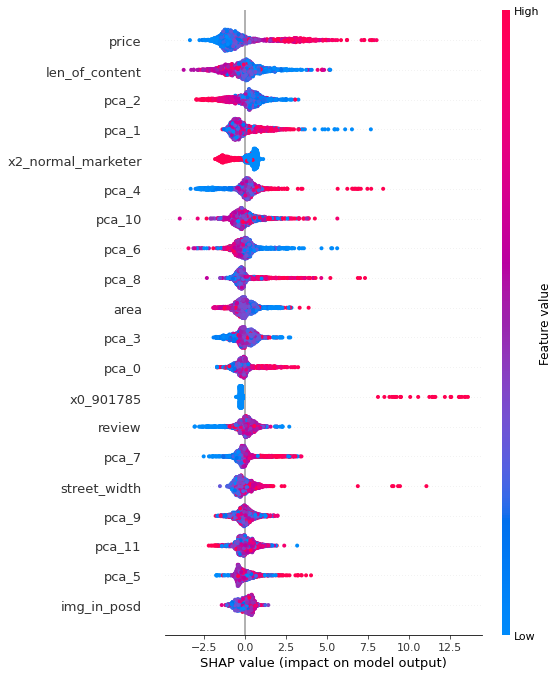

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
N_FOLDS =5
k_folds = KFold(n_splits=N_FOLDS, shuffle=True)

# convert y values into appropriate form
y_array = y.values.reshape(-1, 1)

In [ ]:
model_rmses = []
test_preds = np.zeros((X_test.shape[0], 1))

for train_idx, val_idx in tqdm(k_folds.split(X, y)):
    train_split = X.iloc[train_idx].copy()
    train_labels = y.iloc[train_idx].astype(np.float64).copy()
    val_split = X.iloc[val_idx].copy()
    val_labels = y.iloc[val_idx].astype(np.float64).copy()
    
    temp_model = CatBoostRegressor()
    
    # train model for 100 epochs with early stopping
    temp_model.fit(train_split, train_labels, 
               eval_set=(val_split, val_labels), 
               use_best_model=True,
               early_stopping_rounds=early_stop_rounds)
    
    # find log loss for out of fold val data
    model_val_preds = temp_model.predict(val_split)
    
    # calculate mean squared error on val sub-set preds
    fold_rmse = np.sqrt(mean_squared_error(model_val_preds, val_labels))
    model_rmses.append(fold_rmse)
    print(f'Current Fold validation RMSE: {fold_rmse:.4f}')
    
    # make predictions on test set for each fold
    temp_test_preds = temp_model.predict(X_test).reshape(-1, 1)
    test_preds += (temp_test_preds / N_FOLDS)

# convert results to np array
model_rmses = np.array(model_rmses)


0it [00:00, ?it/s]

Learning rate set to 0.055211
0:	learn: 17.6045310	test: 17.7513624	best: 17.7513624 (0)	total: 2.35ms	remaining: 2.35s
1:	learn: 17.5407024	test: 17.6959522	best: 17.6959522 (1)	total: 4.57ms	remaining: 2.28s
2:	learn: 17.5070738	test: 17.6698714	best: 17.6698714 (2)	total: 6.46ms	remaining: 2.15s
3:	learn: 17.4593753	test: 17.6390969	best: 17.6390969 (3)	total: 8.31ms	remaining: 2.07s
4:	learn: 17.4025492	test: 17.6030013	best: 17.6030013 (4)	total: 10.2ms	remaining: 2.03s
5:	learn: 17.3525840	test: 17.5664799	best: 17.5664799 (5)	total: 12.2ms	remaining: 2.02s
6:	learn: 17.3008174	test: 17.5319307	best: 17.5319307 (6)	total: 14.1ms	remaining: 2s
7:	learn: 17.2568707	test: 17.4995462	best: 17.4995462 (7)	total: 16ms	remaining: 1.99s
8:	learn: 17.1886549	test: 17.4634546	best: 17.4634546 (8)	total: 17.9ms	remaining: 1.98s
9:	learn: 17.1523347	test: 17.4348016	best: 17.4348016 (9)	total: 19.9ms	remaining: 1.97s
10:	learn: 17.1174484	test: 17.4316945	best: 17.4316945 (10)	total: 21.7ms	

1it [00:02,  2.38s/it]

969:	learn: 8.3510681	test: 15.6126811	best: 15.6054722 (964)	total: 1.92s	remaining: 59.5ms
970:	learn: 8.3333347	test: 15.6133322	best: 15.6054722 (964)	total: 1.93s	remaining: 57.5ms
971:	learn: 8.3318570	test: 15.6112237	best: 15.6054722 (964)	total: 1.93s	remaining: 55.6ms
972:	learn: 8.3305985	test: 15.6112242	best: 15.6054722 (964)	total: 1.93s	remaining: 53.6ms
973:	learn: 8.3269842	test: 15.6115659	best: 15.6054722 (964)	total: 1.93s	remaining: 51.6ms
974:	learn: 8.3257239	test: 15.6115695	best: 15.6054722 (964)	total: 1.93s	remaining: 49.6ms
975:	learn: 8.3244663	test: 15.6114633	best: 15.6054722 (964)	total: 1.94s	remaining: 47.6ms
976:	learn: 8.3184594	test: 15.6119968	best: 15.6054722 (964)	total: 1.94s	remaining: 45.6ms
977:	learn: 8.3172086	test: 15.6126135	best: 15.6054722 (964)	total: 1.94s	remaining: 43.7ms
978:	learn: 8.3111796	test: 15.6137678	best: 15.6054722 (964)	total: 1.94s	remaining: 41.7ms
979:	learn: 8.3013869	test: 15.6096886	best: 15.6054722 (964)	total: 1

2it [00:04,  2.33s/it]

937:	learn: 8.7161322	test: 14.8681452	best: 14.8658405 (933)	total: 1.93s	remaining: 128ms
938:	learn: 8.7147989	test: 14.8670645	best: 14.8658405 (933)	total: 1.94s	remaining: 126ms
939:	learn: 8.7134903	test: 14.8656723	best: 14.8656723 (939)	total: 1.94s	remaining: 124ms
940:	learn: 8.7034216	test: 14.8625041	best: 14.8625041 (940)	total: 1.94s	remaining: 122ms
941:	learn: 8.7016668	test: 14.8634779	best: 14.8625041 (940)	total: 1.94s	remaining: 120ms
942:	learn: 8.6903132	test: 14.8701786	best: 14.8625041 (940)	total: 1.94s	remaining: 118ms
943:	learn: 8.6889848	test: 14.8702038	best: 14.8625041 (940)	total: 1.95s	remaining: 115ms
944:	learn: 8.6876780	test: 14.8702152	best: 14.8625041 (940)	total: 1.95s	remaining: 113ms
945:	learn: 8.6836839	test: 14.8690946	best: 14.8625041 (940)	total: 1.95s	remaining: 111ms
946:	learn: 8.6816712	test: 14.8692050	best: 14.8625041 (940)	total: 1.95s	remaining: 109ms
947:	learn: 8.6801373	test: 14.8704760	best: 14.8625041 (940)	total: 1.96s	remai

3it [00:06,  2.25s/it]

988:	learn: 8.3930372	test: 16.0526821	best: 16.0444608 (934)	total: 1.92s	remaining: 21.4ms
989:	learn: 8.3902592	test: 16.0534891	best: 16.0444608 (934)	total: 1.92s	remaining: 19.4ms
990:	learn: 8.3890533	test: 16.0534802	best: 16.0444608 (934)	total: 1.93s	remaining: 17.5ms
991:	learn: 8.3880003	test: 16.0539170	best: 16.0444608 (934)	total: 1.93s	remaining: 15.6ms
992:	learn: 8.3868003	test: 16.0539088	best: 16.0444608 (934)	total: 1.93s	remaining: 13.6ms
993:	learn: 8.3856043	test: 16.0539022	best: 16.0444608 (934)	total: 1.93s	remaining: 11.7ms
994:	learn: 8.3843727	test: 16.0531835	best: 16.0444608 (934)	total: 1.93s	remaining: 9.72ms
995:	learn: 8.3825850	test: 16.0546651	best: 16.0444608 (934)	total: 1.94s	remaining: 7.77ms
996:	learn: 8.3728839	test: 16.0566755	best: 16.0444608 (934)	total: 1.94s	remaining: 5.83ms
997:	learn: 8.3716789	test: 16.0567752	best: 16.0444608 (934)	total: 1.94s	remaining: 3.89ms
998:	learn: 8.3704443	test: 16.0558464	best: 16.0444608 (934)	total: 1

4it [00:09,  2.23s/it]

994:	learn: 8.2287226	test: 15.1690697	best: 15.1669504 (986)	total: 1.97s	remaining: 9.9ms
995:	learn: 8.2275328	test: 15.1691279	best: 15.1669504 (986)	total: 1.97s	remaining: 7.92ms
996:	learn: 8.2265244	test: 15.1689044	best: 15.1669504 (986)	total: 1.97s	remaining: 5.94ms
997:	learn: 8.2138681	test: 15.1693466	best: 15.1669504 (986)	total: 1.98s	remaining: 3.96ms
998:	learn: 8.2128055	test: 15.1689264	best: 15.1669504 (986)	total: 1.98s	remaining: 1.98ms
999:	learn: 8.2009213	test: 15.1737868	best: 15.1669504 (986)	total: 1.98s	remaining: 0us

bestTest = 15.16695038
bestIteration = 986

Shrink model to first 987 iterations.
Current Fold validation RMSE: 15.1670
Learning rate set to 0.055216
0:	learn: 17.5172201	test: 18.0562683	best: 18.0562683 (0)	total: 2.17ms	remaining: 2.16s
1:	learn: 17.4340859	test: 18.0215915	best: 18.0215915 (1)	total: 4.56ms	remaining: 2.27s
2:	learn: 17.3667438	test: 18.0070967	best: 18.0070967 (2)	total: 6.58ms	remaining: 2.19s
3:	learn: 17.3301452	test

5it [00:11,  2.24s/it]

929:	learn: 8.8169517	test: 16.0694501	best: 16.0679439 (917)	total: 1.79s	remaining: 135ms
930:	learn: 8.8102339	test: 16.0676577	best: 16.0676577 (930)	total: 1.79s	remaining: 133ms
931:	learn: 8.8068108	test: 16.0673746	best: 16.0673746 (931)	total: 1.8s	remaining: 131ms
932:	learn: 8.7818108	test: 16.0618640	best: 16.0618640 (932)	total: 1.8s	remaining: 129ms
933:	learn: 8.7628868	test: 16.0572393	best: 16.0572393 (933)	total: 1.8s	remaining: 127ms
934:	learn: 8.7615159	test: 16.0572812	best: 16.0572393 (933)	total: 1.8s	remaining: 125ms
935:	learn: 8.7601039	test: 16.0573932	best: 16.0572393 (933)	total: 1.8s	remaining: 123ms
936:	learn: 8.7576076	test: 16.0561076	best: 16.0561076 (936)	total: 1.81s	remaining: 122ms
937:	learn: 8.7562641	test: 16.0561427	best: 16.0561076 (936)	total: 1.81s	remaining: 120ms
938:	learn: 8.7432481	test: 16.0476895	best: 16.0476895 (938)	total: 1.81s	remaining: 118ms
939:	learn: 8.7419187	test: 16.0476609	best: 16.0476609 (939)	total: 1.81s	remaining:

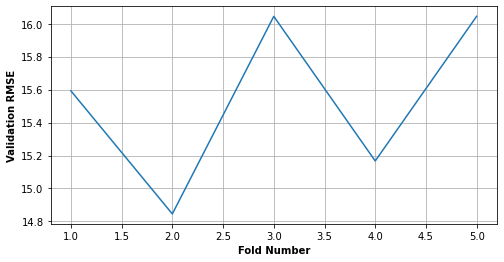

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, model_rmses.shape[0]+1), y=model_rmses)
plt.xlabel("Fold Number", weight='bold')
plt.ylabel("Validation RMSE", weight='bold')
plt.grid()
plt.show()

---------


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

2022-08-22 08:59:57.707316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vscode/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-22 08:59:57.707429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor

lgbmRegressor = LGBMRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lgbmRegressor", lgbmRegressor),
])
model_pipeline.fit(X_train, y_train)
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))

17.731516011704


# XGBRegressor

In [ ]:
from xgboost import XGBRegressor

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# defining model
xgbreg = XGBRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgbreg", xgbreg),
])
# taking positive because cross val score returns -ve values
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))
# printing the output
# print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

17.69714514085863

In [ ]:
# print(f"Scores - {results}\nMean - {sum(results)/len(results)}")

In [ ]:
def Objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [150, 200, 250, 300]),
        "eta": trial.suggest_loguniform("eta",1e-2,0.1),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "min_child_weight": trial.suggest_int("min_child_weight",5,11),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1),
        "max_depth": trial.suggest_categorical("max_depth",[5,7,9,11,13]),
        "random_state": 2021
    }
    
    model = XGBRegressor(**params)
    
    model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
     ("model", model),
    ])
    # taking positive because cross val score returns -ve values
    
    results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

    
    
    return np.abs(np.mean(results))

In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction="minimize", study_name='Xgboost optimization')
study.optimize(Objective, n_trials=10)

[I 2022-08-23 06:18:43,559] A new study created in memory with name: Xgboost optimization


KeyboardInterrupt: 

In [ ]:
XGB_params = study.best_params

study.best_params

{'n_estimators': 150,
 'eta': 0.01408931219016927,
 'subsample': 0.6,
 'min_child_weight': 7,
 'colsample_bytree': 0.9,
 'max_depth': 9}

# LightGBM

In [ ]:
import lightgbm as lgbm


In [ ]:
lgbreg = lgbm.LGBMRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lgbreg", lgbreg),
])
# taking positive because cross val score returns -ve values
results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))

17.583845098316196

In [ ]:
def Objective(trial):
    params = {
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMRegressor(**params)
    model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("model", model),
])
    
    # taking positive because cross val score returns -ve values
    results = cross_val_score(model_pipeline, X_test, y_test.values.ravel(), cv=k, scoring=loss)


    
    return np.abs(np.mean(results))

In [ ]:
study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
study.optimize(Objective, n_trials=20)

[I 2022-08-22 13:43:35,037] A new study created in memory with name: LGBM optimization


[LightGBM] [Warning] lambda_l1 is set=0.0027324893314726573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027324893314726573
[LightGBM] [Warning] feature_fraction is set=0.673213791937495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.673213791937495
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0036591958721555098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036591958721555098
[LightGBM] [Warning] bagging_fraction is set=0.6473712034355852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6473712034355852
[LightGBM] [Warning] lambda_l1 is set=0.0027324893314726573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027324893314726573
[LightGBM] [Warning] feature_fraction is set=0.673213791937495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.673213791937495
[LightGBM] [Warning] ba

[I 2022-08-22 13:43:40,659] Trial 0 finished with value: 18.027206267528438 and parameters: {'lambda_l1': 0.0027324893314726573, 'lambda_l2': 0.0036591958721555098, 'num_leaves': 15, 'feature_fraction': 0.673213791937495, 'bagging_fraction': 0.6473712034355852, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 0 with value: 18.027206267528438.


[LightGBM] [Warning] lambda_l1 is set=0.0027324893314726573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027324893314726573
[LightGBM] [Warning] feature_fraction is set=0.673213791937495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.673213791937495
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0036591958721555098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036591958721555098
[LightGBM] [Warning] bagging_fraction is set=0.6473712034355852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6473712034355852
[LightGBM] [Warning] lambda_l1 is set=5.273290283243408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273290283243408
[LightGBM] [Warning] feature_fraction is set=0.7670910228383434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7670910228383434
[LightGBM] [Warning] bagging_

[I 2022-08-22 13:43:46,180] Trial 1 finished with value: 18.257292623786423 and parameters: {'lambda_l1': 5.273290283243408, 'lambda_l2': 2.046797423248166e-05, 'num_leaves': 235, 'feature_fraction': 0.7670910228383434, 'bagging_fraction': 0.6211655697593575, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 0 with value: 18.027206267528438.


[LightGBM] [Warning] lambda_l1 is set=5.273290283243408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273290283243408
[LightGBM] [Warning] feature_fraction is set=0.7670910228383434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7670910228383434
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.046797423248166e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.046797423248166e-05
[LightGBM] [Warning] bagging_fraction is set=0.6211655697593575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6211655697593575
[LightGBM] [Warning] lambda_l1 is set=3.375197669288683e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.375197669288683e-06
[LightGBM] [Warning] feature_fraction is set=0.9340160822255255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9340160822255255
[LightGBM] [Warning] baggin

[I 2022-08-22 13:43:51,628] Trial 2 finished with value: 18.215261150656186 and parameters: {'lambda_l1': 3.375197669288683e-06, 'lambda_l2': 7.879098243133432e-08, 'num_leaves': 37, 'feature_fraction': 0.9340160822255255, 'bagging_fraction': 0.5008041204212037, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 0 with value: 18.027206267528438.


[LightGBM] [Warning] lambda_l1 is set=3.375197669288683e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.375197669288683e-06
[LightGBM] [Warning] feature_fraction is set=0.9340160822255255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9340160822255255
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.879098243133432e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.879098243133432e-08
[LightGBM] [Warning] bagging_fraction is set=0.5008041204212037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5008041204212037
[LightGBM] [Warning] lambda_l1 is set=0.0026725974004506536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026725974004506536
[LightGBM] [Warning] feature_fraction is set=0.7742626572223614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7742626572223614
[LightGBM] [Warning

[I 2022-08-22 13:43:57,367] Trial 3 finished with value: 18.05098679272451 and parameters: {'lambda_l1': 0.0026725974004506536, 'lambda_l2': 1.647599820626558e-07, 'num_leaves': 167, 'feature_fraction': 0.7742626572223614, 'bagging_fraction': 0.9533654761291588, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 0 with value: 18.027206267528438.


[LightGBM] [Warning] lambda_l1 is set=0.0026725974004506536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026725974004506536
[LightGBM] [Warning] feature_fraction is set=0.7742626572223614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7742626572223614
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.647599820626558e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.647599820626558e-07
[LightGBM] [Warning] bagging_fraction is set=0.9533654761291588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533654761291588
[LightGBM] [Warning] lambda_l1 is set=2.5786671743695784e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5786671743695784e-08
[LightGBM] [Warning] feature_fraction is set=0.8596129819952478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8596129819952478
[LightGBM] [Warni

[I 2022-08-22 13:44:02,924] Trial 4 finished with value: 17.978348078239648 and parameters: {'lambda_l1': 2.5786671743695784e-08, 'lambda_l2': 0.07155332804258717, 'num_leaves': 241, 'feature_fraction': 0.8596129819952478, 'bagging_fraction': 0.5308816488779279, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 4 with value: 17.978348078239648.


[LightGBM] [Warning] lambda_l1 is set=2.5786671743695784e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5786671743695784e-08
[LightGBM] [Warning] feature_fraction is set=0.8596129819952478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8596129819952478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.07155332804258717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07155332804258717
[LightGBM] [Warning] bagging_fraction is set=0.5308816488779279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5308816488779279
[LightGBM] [Warning] lambda_l1 is set=0.0671184232656511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0671184232656511
[LightGBM] [Warning] feature_fraction is set=0.4145580919033948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4145580919033948
[LightGBM] [Warning] baggin

[I 2022-08-22 13:44:08,433] Trial 5 finished with value: 17.661264785760125 and parameters: {'lambda_l1': 0.0671184232656511, 'lambda_l2': 2.840803234758902e-06, 'num_leaves': 164, 'feature_fraction': 0.4145580919033948, 'bagging_fraction': 0.7345362255981351, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 5 with value: 17.661264785760125.


[LightGBM] [Warning] lambda_l1 is set=0.0671184232656511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0671184232656511
[LightGBM] [Warning] feature_fraction is set=0.4145580919033948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4145580919033948
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.840803234758902e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.840803234758902e-06
[LightGBM] [Warning] bagging_fraction is set=0.7345362255981351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7345362255981351
[LightGBM] [Warning] lambda_l1 is set=3.0956552762996864e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0956552762996864e-07
[LightGBM] [Warning] feature_fraction is set=0.6145972168935904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145972168935904
[LightGBM] [Warning] ba

[I 2022-08-22 13:44:13,904] Trial 6 finished with value: 17.635979297303695 and parameters: {'lambda_l1': 3.0956552762996864e-07, 'lambda_l2': 6.896737154103232e-05, 'num_leaves': 94, 'feature_fraction': 0.6145972168935904, 'bagging_fraction': 0.7843502972965222, 'bagging_freq': 2, 'min_child_samples': 79}. Best is trial 6 with value: 17.635979297303695.


[LightGBM] [Warning] lambda_l1 is set=3.0956552762996864e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0956552762996864e-07
[LightGBM] [Warning] feature_fraction is set=0.6145972168935904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145972168935904
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.896737154103232e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.896737154103232e-05
[LightGBM] [Warning] bagging_fraction is set=0.7843502972965222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7843502972965222
[LightGBM] [Warning] lambda_l1 is set=0.014632674288485366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014632674288485366
[LightGBM] [Warning] feature_fraction is set=0.4855858812456263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4855858812456263
[LightGBM] [Warning

[I 2022-08-22 13:44:19,621] Trial 7 finished with value: 17.840148716403732 and parameters: {'lambda_l1': 0.014632674288485366, 'lambda_l2': 1.1566449829858428e-06, 'num_leaves': 247, 'feature_fraction': 0.4855858812456263, 'bagging_fraction': 0.8978168367377499, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 6 with value: 17.635979297303695.


[LightGBM] [Warning] lambda_l1 is set=0.014632674288485366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014632674288485366
[LightGBM] [Warning] feature_fraction is set=0.4855858812456263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4855858812456263
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.1566449829858428e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1566449829858428e-06
[LightGBM] [Warning] bagging_fraction is set=0.8978168367377499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8978168367377499
[LightGBM] [Warning] lambda_l1 is set=0.9088898271096835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9088898271096835
[LightGBM] [Warning] feature_fraction is set=0.7718349390293184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7718349390293184
[LightGBM] [Warning] bagg

[I 2022-08-22 13:44:25,263] Trial 8 finished with value: 17.886239642400128 and parameters: {'lambda_l1': 0.9088898271096835, 'lambda_l2': 0.008323963457981826, 'num_leaves': 63, 'feature_fraction': 0.7718349390293184, 'bagging_fraction': 0.7778600319983167, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 6 with value: 17.635979297303695.


[LightGBM] [Warning] lambda_l1 is set=0.9088898271096835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9088898271096835
[LightGBM] [Warning] feature_fraction is set=0.7718349390293184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7718349390293184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.008323963457981826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008323963457981826
[LightGBM] [Warning] bagging_fraction is set=0.7778600319983167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7778600319983167
[LightGBM] [Warning] lambda_l1 is set=0.0009131747506173059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009131747506173059
[LightGBM] [Warning] feature_fraction is set=0.6871493527382035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6871493527382035
[LightGBM] [Warning] baggin

[I 2022-08-22 13:44:31,171] Trial 9 finished with value: 17.88887447686158 and parameters: {'lambda_l1': 0.0009131747506173059, 'lambda_l2': 0.5174345502721001, 'num_leaves': 27, 'feature_fraction': 0.6871493527382035, 'bagging_fraction': 0.7489033170969763, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 6 with value: 17.635979297303695.


[LightGBM] [Warning] lambda_l1 is set=0.0009131747506173059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009131747506173059
[LightGBM] [Warning] feature_fraction is set=0.6871493527382035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6871493527382035
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.5174345502721001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5174345502721001
[LightGBM] [Warning] bagging_fraction is set=0.7489033170969763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7489033170969763
[LightGBM] [Warning] lambda_l1 is set=2.2035351149782886e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2035351149782886e-06
[LightGBM] [Warning] feature_fraction is set=0.563764575016302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.563764575016302
[LightGBM] [Warning] bagg

[I 2022-08-22 13:44:36,878] Trial 10 finished with value: 17.660126107661153 and parameters: {'lambda_l1': 2.2035351149782886e-06, 'lambda_l2': 7.3606302204766205, 'num_leaves': 87, 'feature_fraction': 0.563764575016302, 'bagging_fraction': 0.8871997392085322, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 6 with value: 17.635979297303695.


[LightGBM] [Warning] lambda_l1 is set=2.2035351149782886e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2035351149782886e-06
[LightGBM] [Warning] feature_fraction is set=0.563764575016302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.563764575016302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.3606302204766205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3606302204766205
[LightGBM] [Warning] bagging_fraction is set=0.8871997392085322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8871997392085322
[LightGBM] [Warning] lambda_l1 is set=6.295578698484151e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.295578698484151e-06
[LightGBM] [Warning] feature_fraction is set=0.5677661984034983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5677661984034983
[LightGBM] [Warning] bagg

[I 2022-08-22 13:44:42,679] Trial 11 finished with value: 17.694331631599415 and parameters: {'lambda_l1': 6.295578698484151e-06, 'lambda_l2': 4.788697726237129, 'num_leaves': 94, 'feature_fraction': 0.5677661984034983, 'bagging_fraction': 0.8657928208857611, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 6 with value: 17.635979297303695.


[LightGBM] [Warning] lambda_l1 is set=6.295578698484151e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.295578698484151e-06
[LightGBM] [Warning] feature_fraction is set=0.5677661984034983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5677661984034983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.788697726237129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.788697726237129
[LightGBM] [Warning] bagging_fraction is set=0.8657928208857611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657928208857611
[LightGBM] [Warning] lambda_l1 is set=6.351806717639585e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.351806717639585e-08
[LightGBM] [Warning] feature_fraction is set=0.5627399089203216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5627399089203216
[LightGBM] [Warning] baggin

[I 2022-08-22 13:44:48,379] Trial 12 finished with value: 17.749031878361517 and parameters: {'lambda_l1': 6.351806717639585e-08, 'lambda_l2': 0.0003317927612643772, 'num_leaves': 110, 'feature_fraction': 0.5627399089203216, 'bagging_fraction': 0.8629969074529773, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 6 with value: 17.635979297303695.


[LightGBM] [Warning] lambda_l1 is set=6.351806717639585e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.351806717639585e-08
[LightGBM] [Warning] feature_fraction is set=0.5627399089203216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5627399089203216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0003317927612643772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003317927612643772
[LightGBM] [Warning] bagging_fraction is set=0.8629969074529773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629969074529773
[LightGBM] [Warning] lambda_l1 is set=1.0383836841297913e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0383836841297913e-05
[LightGBM] [Warning] feature_fraction is set=0.5941458117367121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5941458117367121
[LightGBM] [Warni

[I 2022-08-22 13:44:53,943] Trial 13 finished with value: 17.56906517929814 and parameters: {'lambda_l1': 1.0383836841297913e-05, 'lambda_l2': 0.0001273602458837232, 'num_leaves': 149, 'feature_fraction': 0.5941458117367121, 'bagging_fraction': 0.9853374390599876, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 13 with value: 17.56906517929814.


[LightGBM] [Warning] lambda_l1 is set=1.0383836841297913e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0383836841297913e-05
[LightGBM] [Warning] feature_fraction is set=0.5941458117367121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5941458117367121
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0001273602458837232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001273602458837232
[LightGBM] [Warning] bagging_fraction is set=0.9853374390599876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853374390599876
[LightGBM] [Warning] lambda_l1 is set=2.7831349622466223e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7831349622466223e-05
[LightGBM] [Warning] feature_fraction is set=0.6284209486847289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6284209486847289
[LightGBM] [War

[I 2022-08-22 13:44:59,489] Trial 14 finished with value: 17.51695066843782 and parameters: {'lambda_l1': 2.7831349622466223e-05, 'lambda_l2': 9.871318553084152e-05, 'num_leaves': 144, 'feature_fraction': 0.6284209486847289, 'bagging_fraction': 0.9793659037764446, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 14 with value: 17.51695066843782.


[LightGBM] [Warning] lambda_l1 is set=2.7831349622466223e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7831349622466223e-05
[LightGBM] [Warning] feature_fraction is set=0.6284209486847289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6284209486847289
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.871318553084152e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.871318553084152e-05
[LightGBM] [Warning] bagging_fraction is set=0.9793659037764446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9793659037764446
[LightGBM] [Warning] lambda_l1 is set=6.469608990433207e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.469608990433207e-05
[LightGBM] [Warning] feature_fraction is set=0.4944610561624817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4944610561624817
[LightGBM] [Warni

[I 2022-08-22 13:45:05,051] Trial 15 finished with value: 17.256760731638586 and parameters: {'lambda_l1': 6.469608990433207e-05, 'lambda_l2': 0.0008725617929281465, 'num_leaves': 153, 'feature_fraction': 0.4944610561624817, 'bagging_fraction': 0.99937348508537, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 15 with value: 17.256760731638586.


[LightGBM] [Warning] lambda_l1 is set=6.469608990433207e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.469608990433207e-05
[LightGBM] [Warning] feature_fraction is set=0.4944610561624817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4944610561624817
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0008725617929281465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008725617929281465
[LightGBM] [Warning] bagging_fraction is set=0.99937348508537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99937348508537
[LightGBM] [Warning] lambda_l1 is set=7.955241622729569e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.955241622729569e-05
[LightGBM] [Warning] feature_fraction is set=0.4604054903678212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4604054903678212
[LightGBM] [Warning] ba

[I 2022-08-22 13:45:10,762] Trial 16 finished with value: 17.29003284144742 and parameters: {'lambda_l1': 7.955241622729569e-05, 'lambda_l2': 0.0019669046311144634, 'num_leaves': 202, 'feature_fraction': 0.4604054903678212, 'bagging_fraction': 0.9967438761461258, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 15 with value: 17.256760731638586.


[LightGBM] [Warning] lambda_l1 is set=7.955241622729569e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.955241622729569e-05
[LightGBM] [Warning] feature_fraction is set=0.4604054903678212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4604054903678212
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019669046311144634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019669046311144634
[LightGBM] [Warning] bagging_fraction is set=0.9967438761461258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967438761461258
[LightGBM] [Warning] lambda_l1 is set=8.172699466741588e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.172699466741588e-05
[LightGBM] [Warning] feature_fraction is set=0.42209234714931704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42209234714931704
[LightGBM] [Warni

[I 2022-08-22 13:45:16,364] Trial 17 finished with value: 17.370290178940337 and parameters: {'lambda_l1': 8.172699466741588e-05, 'lambda_l2': 0.002242782583723396, 'num_leaves': 201, 'feature_fraction': 0.42209234714931704, 'bagging_fraction': 0.9156136144131697, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 15 with value: 17.256760731638586.


[LightGBM] [Warning] lambda_l1 is set=8.172699466741588e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.172699466741588e-05
[LightGBM] [Warning] feature_fraction is set=0.42209234714931704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42209234714931704
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.002242782583723396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002242782583723396
[LightGBM] [Warning] bagging_fraction is set=0.9156136144131697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9156136144131697
[LightGBM] [Warning] lambda_l1 is set=0.000198392444570193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000198392444570193
[LightGBM] [Warning] feature_fraction is set=0.49313088639958536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49313088639958536
[LightGBM] [Warning

[I 2022-08-22 13:45:21,873] Trial 18 finished with value: 17.852756121967484 and parameters: {'lambda_l1': 0.000198392444570193, 'lambda_l2': 0.036524774322189583, 'num_leaves': 201, 'feature_fraction': 0.49313088639958536, 'bagging_fraction': 0.4328320577052066, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 15 with value: 17.256760731638586.


[LightGBM] [Warning] lambda_l1 is set=0.000198392444570193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000198392444570193
[LightGBM] [Warning] feature_fraction is set=0.49313088639958536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49313088639958536
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.036524774322189583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036524774322189583
[LightGBM] [Warning] bagging_fraction is set=0.4328320577052066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4328320577052066
[LightGBM] [Warning] lambda_l1 is set=3.850439178740483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.850439178740483e-07
[LightGBM] [Warning] feature_fraction is set=0.47628500567017584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47628500567017584
[LightGBM] [Warning

[I 2022-08-22 13:45:27,636] Trial 19 finished with value: 17.40039768571184 and parameters: {'lambda_l1': 3.850439178740483e-07, 'lambda_l2': 0.0007679788032317499, 'num_leaves': 195, 'feature_fraction': 0.47628500567017584, 'bagging_fraction': 0.8231307211952978, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 15 with value: 17.256760731638586.


[LightGBM] [Warning] lambda_l1 is set=3.850439178740483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.850439178740483e-07
[LightGBM] [Warning] feature_fraction is set=0.47628500567017584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47628500567017584
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0007679788032317499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007679788032317499
[LightGBM] [Warning] bagging_fraction is set=0.8231307211952978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8231307211952978


In [ ]:
lgb_params = study.best_params
study.best_params

{'lambda_l1': 6.469608990433207e-05,
 'lambda_l2': 0.0008725617929281465,
 'num_leaves': 153,
 'feature_fraction': 0.4944610561624817,
 'bagging_fraction': 0.99937348508537,
 'bagging_freq': 3,
 'min_child_samples': 46}

-------

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
final_estimator =  CatBoostRegressor( random_seed=13, verbose=200)

estimators = [('xgb', XGBRegressor( )),
        #       ('lgb', lgbm.LGBMRegressor(**lgb_params))
                  ("reg", reg),
                ("lgbreg", lgbreg),
              ]
# model_pipeline = Pipeline(steps=[
# ("preprocessor", preprocessor),
# ("final_estimator", final_estimator),
# ])
reg = StackingRegressor(
        estimators=estimators,
         final_estimator=final_estimator)
model_pipeline = Pipeline(steps=[
("preprocessor", preprocessor),
("reg", reg),
])
cb_reg_1 = model_pipeline.fit(X_train , y_train)

Learning rate set to 0.046011
0:	learn: 17.6066622	total: 53.5ms	remaining: 53.5s
200:	learn: 14.1318762	total: 1.56s	remaining: 6.19s
400:	learn: 13.0612641	total: 3.74s	remaining: 5.59s
600:	learn: 12.1803399	total: 5.26s	remaining: 3.5s
800:	learn: 11.4690531	total: 7.25s	remaining: 1.8s
999:	learn: 10.8385800	total: 9.17s	remaining: 0us
Learning rate set to 0.044415
0:	learn: 17.6037342	total: 2.71ms	remaining: 2.7s
200:	learn: 14.0154480	total: 189ms	remaining: 750ms
400:	learn: 12.8238079	total: 364ms	remaining: 544ms
600:	learn: 11.8765527	total: 531ms	remaining: 352ms
800:	learn: 11.0499783	total: 722ms	remaining: 179ms
999:	learn: 10.3658837	total: 886ms	remaining: 0us
Learning rate set to 0.044415
0:	learn: 17.6484226	total: 846us	remaining: 846ms
200:	learn: 14.0789160	total: 256ms	remaining: 1.02s
400:	learn: 13.0008968	total: 455ms	remaining: 680ms
600:	learn: 12.1115965	total: 614ms	remaining: 408ms
800:	learn: 11.3946643	total: 772ms	remaining: 192ms
999:	learn: 10.72177

In [ ]:
results = cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)

np.abs(np.mean(results))

Learning rate set to 0.035685
0:	learn: 16.5291536	total: 762us	remaining: 762ms
200:	learn: 12.6104389	total: 78ms	remaining: 310ms
400:	learn: 10.6364964	total: 152ms	remaining: 226ms
600:	learn: 9.0748810	total: 229ms	remaining: 152ms
800:	learn: 7.8598089	total: 303ms	remaining: 75.2ms
999:	learn: 6.8955668	total: 378ms	remaining: 0us
Learning rate set to 0.034446
0:	learn: 16.6851832	total: 627us	remaining: 627ms
200:	learn: 12.8463189	total: 74ms	remaining: 294ms
400:	learn: 10.3164007	total: 145ms	remaining: 217ms
600:	learn: 8.4653829	total: 218ms	remaining: 145ms
800:	learn: 7.1916539	total: 290ms	remaining: 72ms
999:	learn: 6.3590940	total: 361ms	remaining: 0us
Learning rate set to 0.034446
0:	learn: 16.6560941	total: 697us	remaining: 697ms
200:	learn: 12.9255426	total: 74.2ms	remaining: 295ms
400:	learn: 10.3633138	total: 151ms	remaining: 225ms
600:	learn: 8.4839663	total: 233ms	remaining: 155ms
800:	learn: 7.1131550	total: 311ms	remaining: 77.3ms
999:	learn: 6.1042861	total

16.990032659185974

In [ ]:
# import joblib
# joblib.dump(cb_reg_1, "reg.pkl")

NameError: name 'cb_reg_1' is not defined